# Land Type Classification using Sentinel-2 Satellite Images

#### This project focuses on leveraging Deep Neural Networks (DNNs) to classify different land types (such as agriculture, water, urban areas, desert, roads, and trees).

## Step 1: Data Collection:

#### EuroSAT is a well-known dataset of Sentinel-2 satellite images designed for land use and land cover classification.
Download dataset [EuroSAT Dataset (RGB)](https://madm.dfki.de/files/sentinel/EuroSAT.zip)

#### Path to the dataset: 'EuroSAT/2750/' with 10 subfolders each containing around 2000-3000 images.

## Step 2: Data Exploration:

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import cv2
from collections import Counter

In [2]:
# Define dataset path
dataset_path = "EuroSAT/2750/"

In [3]:
# List all land type categories
categories = os.listdir(dataset_path)

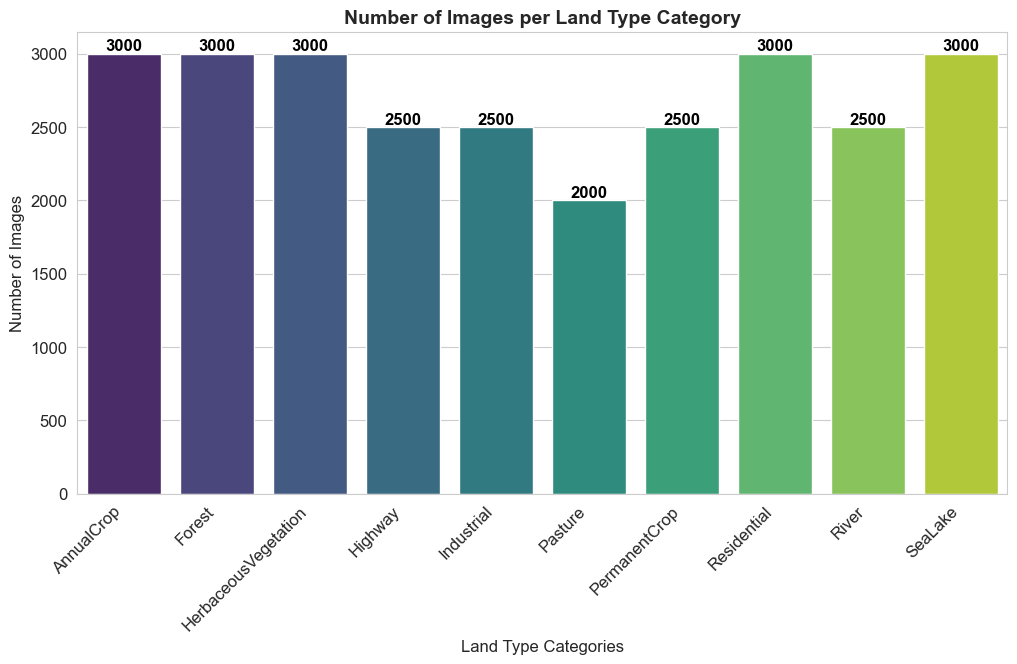

In [4]:
# Count the number of images per category
image_count = {}
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_count[category] = len(os.listdir(category_path))

# Set Seaborn style
sns.set_style("whitegrid")

# Create the bar plot (fix: assign `x` to `hue` and disable legend)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(image_count.keys()), y=list(image_count.values()), hue=list(image_count.keys()), palette="viridis", legend=False)

# Add exact counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Improve readability
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title('Number of Images per Land Type Category', fontsize=14, fontweight='bold')
plt.xlabel('Land Type Categories', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Show the plot
plt.show()

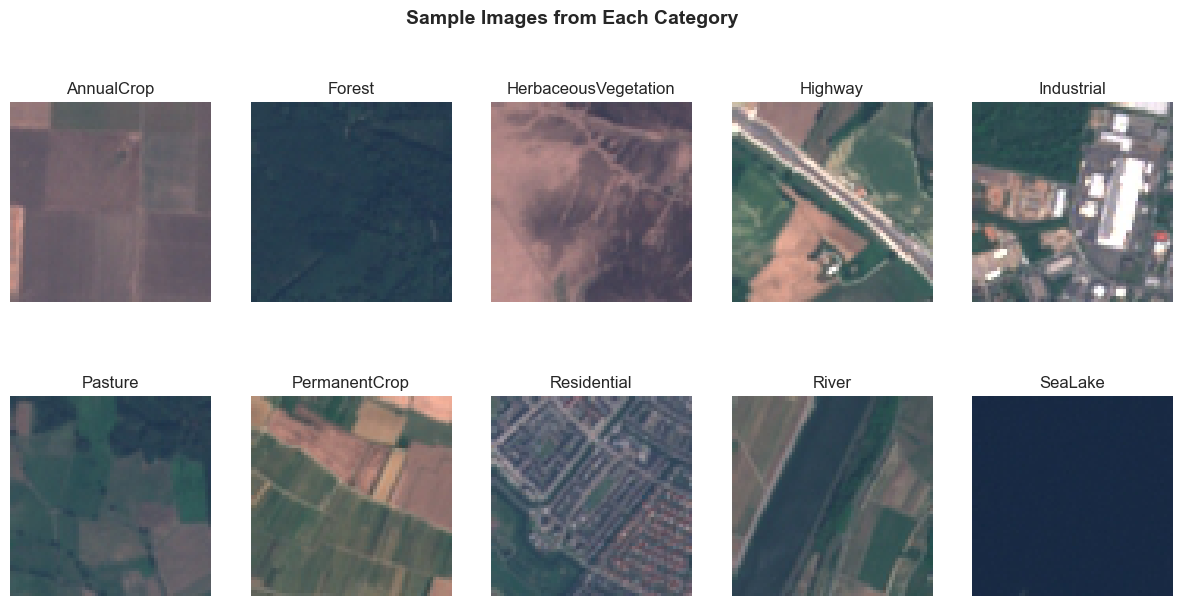

In [5]:
# Visualize sample images from each category
plt.figure(figsize=(15, 7))
for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    sample_image = os.listdir(category_path)[0]
    img = Image.open(os.path.join(category_path, sample_image))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')
plt.suptitle('Sample Images from Each Category', fontsize=14, fontweight='bold')
plt.show()

In [6]:
# Check for missing data or corrupted images
def check_images(dataset_path):
    corrupted = []
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        for img_name in os.listdir(category_path):
            try:
                img = Image.open(os.path.join(category_path, img_name))
                img.verify()
            except Exception as e:
                corrupted.append((category, img_name))
    return corrupted

In [7]:
corrupted_images = check_images(dataset_path)
print(f"Number of corrupted images: {len(corrupted_images)}")
if corrupted_images:
    print("Corrupted images:", corrupted_images)

Number of corrupted images: 0


In [8]:
# Analyze image sizes
image_shapes = []

# Iterate over all categories
for cls in categories:
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    
    # Iterate over all images in the category
    for img_name in images:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        
        if img is not None:  # Avoid errors due to unreadable images
            image_shapes.append(img.shape)

# Count the occurrences of each shape
print("Image Dimensions (All Images):", Counter(image_shapes))


# # Iterate through all images to check their dimensions
# for class_folder in os.listdir(dataset_path):
#     class_path = os.path.join(dataset_path, class_folder)
#     if os.path.isdir(class_path):
#         for img_name in os.listdir(class_path):
#             img_path = os.path.join(class_path, img_name)
#             img = Image.open(img_path)
#             image_shapes.append(img.size)

# # Check unique image sizes
# unique_sizes = set(all_shapes)
# print("Unique image sizes:", unique_sizes)

Image Dimensions (All Images): Counter({(64, 64, 3): 27000})


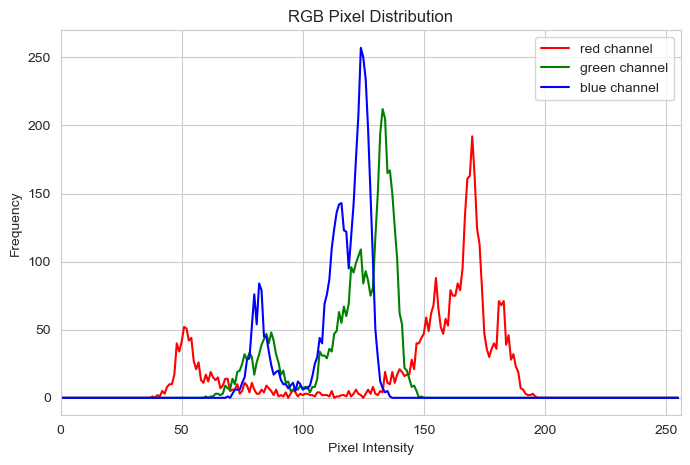

In [9]:
# Visualize RGB histograms for sample image

import random

def plot_pixel_distribution(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    colors = ("red", "green", "blue")
    plt.figure(figsize=(8, 5))

    for i, color in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=color, label=f"{color} channel")
        plt.xlim([0, 256])

    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("RGB Pixel Distribution")
    plt.show()

# Test with one random image
random_img_path = os.path.join(dataset_path, "AnnualCrop", random.choice(os.listdir(os.path.join(dataset_path, "AnnualCrop"))))
plot_pixel_distribution(random_img_path)

#### Key Observations:
- The **blue** channel has a strong peak around 100, meaning the image has a **dominant blue tone**.
- The **green** channel has a peak around 90-110, suggesting a **significant presence of green shades**.
- The **red** channel has multiple smaller peaks spread across 50-150, indicating that **red** tones are **distributed more variably**.
- There are almost no pixels beyond **200** intensity, meaning the image does not have pure **white** or very bright areas.

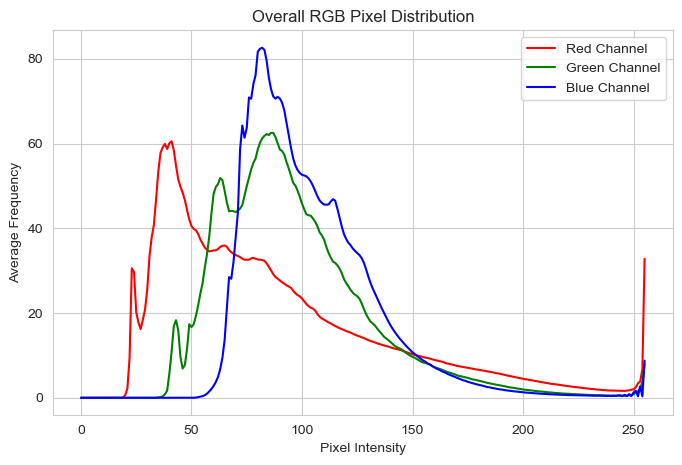

In [10]:
# RGB Pixel Distribution Graph
def compute_pixel_distribution(dataset_path, categories):
    total_hist_r = np.zeros(256)
    total_hist_g = np.zeros(256)
    total_hist_b = np.zeros(256)
    
    total_images = 0

    for category in categories:
        class_folder = os.path.join(dataset_path, category)
        image_files = os.listdir(class_folder)
        
        for img_name in image_files:
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            hist_r = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
            hist_g = cv2.calcHist([img], [1], None, [256], [0, 256]).flatten()
            hist_b = cv2.calcHist([img], [2], None, [256], [0, 256]).flatten()
            
            total_hist_r += hist_r
            total_hist_g += hist_g
            total_hist_b += hist_b
            total_images += 1

    # Normalize histograms
    total_hist_r /= total_images
    total_hist_g /= total_images
    total_hist_b /= total_images

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(total_hist_r, color="red", label="Red Channel")
    plt.plot(total_hist_g, color="green", label="Green Channel")
    plt.plot(total_hist_b, color="blue", label="Blue Channel")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Average Frequency")
    plt.legend()
    plt.title("Overall RGB Pixel Distribution")
    plt.show()

# Compute and plot pixel intensity distribution for all images
compute_pixel_distribution(dataset_path, categories)

## 📊 Understanding the RGB Pixel Distribution Graph

### **Graph Explanation**
- **X-axis**: Represents **pixel intensity values** (0-255), where:
  - `0` → **Black** (lowest intensity)
  - `255` → **White** (highest intensity)
- **Y-axis**: Represents the **average frequency** of each intensity across all images.
- **Curves Represent Different Channels:**
  - 🔴 **Red Channel**
  - 🟢 **Green Channel**
  - 🔵 **Blue Channel**

### **📌 Key Insights from the Graph**
1. **Blue Dominance Around 80-100 Intensity**  
   - The blue curve has the highest peak around **80-100**.
   - This suggests that many images in the dataset contain **blueish tones** (e.g., water bodies, sky, or shadows).

2. **Green and Red Are More Spread Out**  
   - The **green curve** peaks between **50-100**, indicating the presence of **vegetation or natural elements**.
   - The **red curve** is more distributed, with peaks around **40-60**, suggesting the presence of **soil, buildings, or reddish tones**.

3. **Low Intensities (Shadows/Dark Areas)**  
   - The left side of the graph (0-50) shows noticeable activity in **red and green**, meaning some images have **dark or shadowed areas**.

4. **High Intensities (Bright Areas)**  
   - The right side of the graph (200-255) has lower values, meaning fewer **very bright areas** exist in the dataset.

## Step 3: Data Preprocessing:

In [4]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [5]:
# Define transformation (without normalization)
transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to tensors
])

In [6]:
# Load dataset
dataset = ImageFolder(root=dataset_path, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [7]:
# Compute mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
num_samples = 0

for images, _ in loader:
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, 3, -1)  # Flatten image pixels
    mean += images.mean(dim=[0, 2])  # Compute mean per channel
    std += images.std(dim=[0, 2])  # Compute std per channel
    num_samples += batch_samples

mean /= num_samples
std /= num_samples

print(f"Dataset Mean: {mean.tolist()}")
print(f"Dataset Std: {std.tolist()}")

Dataset Mean: [0.0053816381841897964, 0.005943409167230129, 0.006373167037963867]
Dataset Std: [0.002342385705560446, 0.001672859420068562, 0.001422425964847207]


In [8]:
# Define preprocessing transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15, interpolation=transforms.InterpolationMode.BICUBIC, fill=128),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# transforms.Grayscale(num_output_channels=1),  # we not Convert to grayscaleabs
# Keep RGB because color carries meaningful features.

# transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # well crop alot of details from images

# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.0054, 0.0059, 0.0064], std=[0.0023, 0.0017, 0.0014])  # Use computed values
# ])

#### Why These Specific Transformations?
Data augmentation helps improve model generalization by introducing variations in the training data. Here’s why each transformation is useful:

- **`transforms.RandomHorizontalFlip(p=0.5)`**  
  - Flips the image horizontally with a 50% chance.  
  - Useful for datasets where objects can appear in either left or right orientations.  

- **`transforms.RandomVerticalFlip(p=0.5)`**  
  - Flips the image vertically with a 50% chance.  
  - Helpful for satellite or aerial images where features might not have a fixed orientation.  

- **`transforms.RandomRotation(15)`**  
  - Rotates the image randomly by up to ±15 degrees.  
  - Helps the model learn rotation-invariant features, useful for real-world scenarios where objects might not always be perfectly aligned.  

- **`transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)`**  
  - Randomly adjusts brightness, contrast, saturation, and hue.  
  - Improves robustness to lighting variations and different weather conditions, making the model more adaptable to real-world images.  

These transformations enhance the diversity of the training data, reducing overfitting and improving the model’s performance. 🚀

- **`ToTensor()`** → Converts image to PyTorch tensor format.
- **`Normalize(mean, std)`** → Uses your dataset-specific values to improve model convergence and stability.

In [9]:
# Load Dataset with Transformations
dataset = ImageFolder(root=dataset_path, transform=transform)

In [10]:
# Split the Dataset
train_size = int(0.7 * len(dataset))  # 70% Training
val_size = int(0.2 * len(dataset))    # 20% Validation
test_size = len(dataset) - train_size - val_size  # 10% Test

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [11]:
# Create DataLoaders
# DataLoaders help in loading batches efficiently during training:

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Visualizing Augmented Images
Since we've applied transformations (flipping, rotation, color jitter), it's essential to visualize the modified images to ensure they're applied correctly.

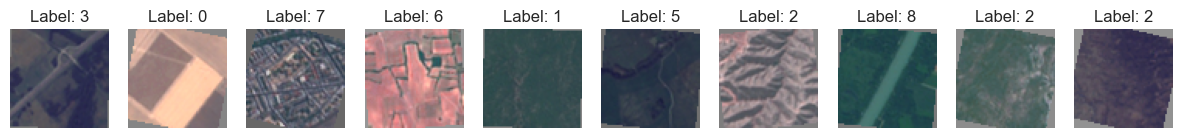

In [114]:
# Function to Display Sample Images from Dataset
def show_images(dataset, mean, std, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    # Convert mean and std lists to NumPy arrays for element-wise operations
    mean = np.array(mean.tolist())  # Use mean.tolist() dynamically
    std = np.array(std.tolist())    # Use std.tolist() dynamically

    for i in range(num_images):
        img, label = dataset[i]
        img = img.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

        # Reverse normalization (denormalize)
        img = img * std + mean
        img = np.clip(img, 0, 1)  # Keep pixel values in valid range

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.show()

# Call function with dynamically computed mean & std
show_images(train_dataset, mean, std)

#### Class Distribution Visualization (After Preprocessing)

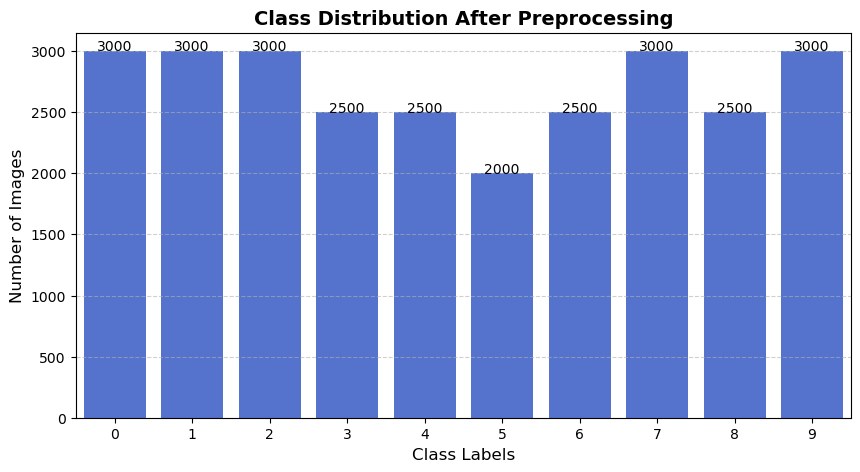

In [33]:
# Extract class labels
labels = [label for _, label in dataset]  # Extract labels from dataset
label_counts = Counter(labels)

# Convert data into a format suitable for seaborn
data = {"Class Labels": list(label_counts.keys()), "Count": list(label_counts.values())}

# Plot using Seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x="Class Labels", y="Count", data=data, color="royalblue")

# Add labels & title
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class Distribution After Preprocessing", fontsize=14, fontweight="bold")

# Show counts on top of bars
for i, count in enumerate(label_counts.values()):
    plt.text(i, count + 2, str(count), ha="center", fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

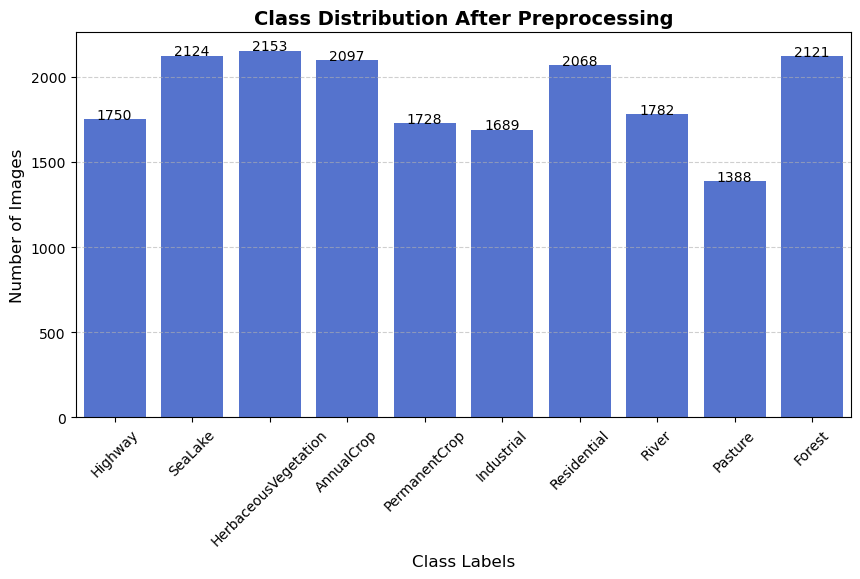

In [31]:
# Extract class labels from the train dataset
labels = [train_dataset.dataset.targets[i] for i in train_dataset.indices]
label_counts = Counter(labels)

# Convert to list format for seaborn
class_labels = [dataset.classes[i] for i in label_counts.keys()]
counts = list(label_counts.values())

# Plot using Seaborn
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=class_labels, y=counts, color="royalblue")

# Add labels & title
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class Distribution After Preprocessing (Training Data)", fontsize=14, fontweight="bold")

# Show counts on top of bars
for i, count in enumerate(counts):
    ax.text(i, count + 2, str(count), ha="center", fontsize=10)

plt.xticks(rotation=45, fontsize=10)  # Rotate labels for better visibility
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

#### PCA & t-SNE for Feature Visualization
Dimensionality reduction techniques like t-SNE or PCA can visualize image clusters.

#### Benefits of Using PCA & t-SNE in EDA
- **Feature Understanding**:
  - Helps inspect how well the dataset is structured.
  - Identifies similarities and differences between images.
- **Class Distribution & Clustering**:
  - Shows whether different classes form distinct clusters.
  - Detects overlapping or misclassified classes.
- **Detecting Anomalies**:
  - Helps spot outliers in the dataset.
  - Unusual points may indicate data quality issues.
- **Model Selection Insight**:
  - If classes are well-separated, a simple classifier like Logistic Regression might work.
  - If classes overlap, a deep learning model may be needed.

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [29]:
# Function to extract image features from the dataset
def extract_features(dataloader):
    features = []
    labels = []
    
    for images, lbls in dataloader:
        images = images.view(images.size(0), -1)  # Flatten images
        features.append(images.numpy())
        labels.extend(lbls.numpy())
    
    return np.vstack(features), np.array(labels)

In [30]:
# Extract features from training set
features, labels = extract_features(train_loader)

In [31]:
# Apply PCA (reduce to 2 components for visualization)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

In [32]:
# Apply t-SNE (reduce to 2 components for visualization)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(features)

Text(0, 0.5, 'Principal Component 2')

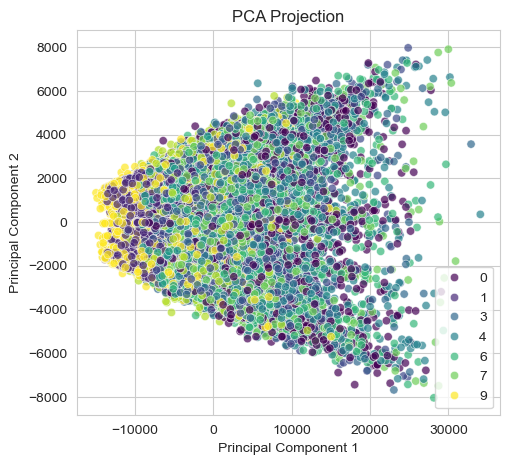

In [33]:
# Plot PCA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

Text(0, 0.5, 't-SNE Component 2')

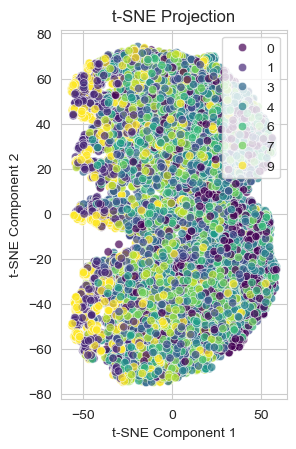

In [34]:
# Plot t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Projection")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

#### Conclusion:
- High overlap in PCA & t-SNE means the dataset does not have well-separated clusters **(not linearly separable)**.
  - This suggests that images from different classes look somewhat similar in feature space.
  - Simple classifiers like logistic regression or linear SVM may struggle.
- t-SNE improves local clustering slightly, but classes are still mixed.
  - This tells us that even with a non-linear method, the data does not have naturally distinct groups.

#### We might need better feature extraction (e.g., CNN embeddings) to extract better features before classification to classify the data well.

## Step 4: Modelling:

In [12]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
# Device configuration (ignore CUDA)
device = torch.device("cpu")